<a href="https://colab.research.google.com/github/Htets-Corner/SYNTHBUSTER_RAISE-1k/blob/main/syn_real_mobilevit050.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
# Step 0: Data Preparation

# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. Define dataset path
import os

# Update this path if needed
dataset_path = "/content/drive/MyDrive/Dataset"

train_dir = os.path.join(dataset_path, "train")
test_dir  = os.path.join(dataset_path, "test")

print("Train path:", train_dir)
print("Test path:", test_dir)

# 3. Import necessary libraries
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 4. Define image transformations (resize, normalization)
# MobileViT usually works with 256x256 or 224x224 input
image_size = 256

transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],   # normalize to [-1, 1]
        std=[0.5, 0.5, 0.5]
    )
])

# 5. Load train and test datasets
#train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
#test_dataset  = datasets.ImageFolder(root=test_dir, transform=transform)

from torchvision.datasets import ImageFolder

valid_exts = ('.jpg', '.jpeg', '.png', '.PNG', '.bmp', '.tif', '.tiff', '.webp')

train_dataset = ImageFolder(
    root=train_dir,
    transform=transform,
    is_valid_file=lambda path: path.lower().endswith(valid_exts)
)

test_dataset = ImageFolder(
    root=test_dir,
    transform=transform,
    is_valid_file=lambda path: path.lower().endswith(valid_exts)
)


# 6. Create DataLoaders
#batch_size = 32
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# 7. Check class labels
classes = train_dataset.classes
print("Classes:", classes)
print("Train size:", len(train_dataset))
print("Test size:", len(test_dataset))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Train path: /content/drive/MyDrive/Dataset/train
Test path: /content/drive/MyDrive/Dataset/test
Classes: ['ai', 'real']
Train size: 3199
Test size: 800


In [15]:
import os

print("Train/AI files:", len(os.listdir(train_dir + "/ai")))
print("Train/Real files:", len(os.listdir(train_dir + "/real")))
print("Test/AI files:", len(os.listdir(test_dir + "/ai")))
print("Test/Real files:", len(os.listdir(test_dir + "/real")))

# Show first 5 files in each folder
print("Sample AI:", os.listdir(train_dir + "/ai")[:5])
print("Sample Real:", os.listdir(train_dir + "/real")[:5])


Train/AI files: 2400
Train/Real files: 799
Test/AI files: 600
Test/Real files: 200
Sample AI: ['stable-diffusion-2_r179bb406t.png', 'stable-diffusion-2_r0e965ba7t.png', 'firefly_r03f70ccdt.png', 'stable-diffusion-xl_r164c1e13t.png', 'firefly_r138ad247t.png']
Sample Real: ['r15c91802t.png', 'r0db6cc31t.png', 'r1aa53167t.png', 'r05d9d749t.png', 'r13de1e12t.png']


In [16]:
# Run this first cell in Colab
!pip install -q timm        # recommended: timm includes MobileViT variants + pretrained weights
# optional fallback (if you want the standalone implementation)
# !pip install -q git+https://github.com/chinhsuanwu/mobilevit-pytorch.git


In [17]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
import timm
from collections import Counter
print("Torch:", torch.__version__, "Timm:", timm.__version__)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Torch: 2.8.0+cu126 Timm: 1.0.19
Device: cpu


In [18]:
# list available MobileViT-like models in timm
models = timm.list_models('*mobilevit*')
print("MobileViT variants found in timm:", models)

# choose one automatically (you can change this name)
if len(models) == 0:
    raise RuntimeError("No MobileViT models found in timm. You can pip-install a standalone MobileViT repo instead.")
model_name = models[0]   # default to first found; or set e.g. 'mobilevit_xxs' or 'mobilevit_s'
print("Using model:", model_name)



MobileViT variants found in timm: ['mobilevit_s', 'mobilevit_xs', 'mobilevit_xxs', 'mobilevitv2_050', 'mobilevitv2_075', 'mobilevitv2_100', 'mobilevitv2_125', 'mobilevitv2_150', 'mobilevitv2_175', 'mobilevitv2_200']
Using model: mobilevit_s


In [19]:
import timm
import torch
import torch.nn as nn

# 1. Choose model
model_name = "mobilevitv2_050"

# 2. Load pretrained model from timm
model = timm.create_model(model_name, pretrained=True)

# 3. Adapt classifier head for 2 classes (ai, real)
if hasattr(model, "reset_classifier"):
    model.reset_classifier(num_classes=2)
else:
    # fallback if reset_classifier not available
    in_features = model.classifier.in_features
    model.classifier = nn.Linear(in_features, 2)

# 4. Move to device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"✅ Loaded {model_name} with classifier reset to 2 classes")


✅ Loaded mobilevitv2_050 with classifier reset to 2 classes


In [ ]:
# @title
""" import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from collections import Counter
from tqdm import tqdm
import copy
import os

# -------------------------------
# 1) Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# -------------------------------
# 2) Dataset & DataLoader (reuse your train_dataset and test_dataset)
# Handle class imbalance with WeightedRandomSampler
targets = [s[1] for s in train_dataset.samples]
counts = Counter(targets)
class_weights = {cls: 1.0 / count for cls, count in counts.items()}
sample_weights = [class_weights[t] for t in targets]

sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# -------------------------------
# 3) Loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss()  # class indices 0/1
optimizer = optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)  # adjust T_max for epochs

# Mixed precision
scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None

# -------------------------------
# 4) Train & Validation functions
def validate(model, loader):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += images.size(0)
    return running_loss/total, correct/total

def train_one_epoch(model, loader, optimizer, scaler=None):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    loop = tqdm(loader, desc="Train")
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        if scaler is not None:
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += images.size(0)
        loop.set_postfix(loss=running_loss/total, acc=100*correct/total)
    return running_loss/total, correct/total

# -------------------------------
# 5) Training loop with metrics storage
num_epochs = 10
best_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())
save_path = "/content/drive/MyDrive/Dataset/mobilevitv2_050_best.pth"

# Lists to store metrics per epoch
train_losses, train_accs = [], []
val_losses, val_accs = [], []

for epoch in range(num_epochs):
    # Train
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, scaler)
    # Validate
    val_loss, val_acc = validate(model, test_loader)
    # Scheduler step
    scheduler.step()

    # Store metrics
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss {train_loss:.4f} Acc {train_acc:.4f} | Val Loss {val_loss:.4f} Acc {val_acc:.4f}")

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save({
            'epoch': epoch+1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_acc': best_acc
        }, save_path)
        print(f"💾 Best model saved: {save_path}")

# Load best weights at the end
model.load_state_dict(best_model_wts)
print("✅ Training complete, best model loaded.") """


Device: cpu


Epoch 1/10 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch 1/10 [Train]: 100%|██████████| 100/100 [36:18<00:00, 21.78s/it, acc=77.7, loss=0.545]


Epoch 1/10 | Train Loss: 0.5447, Train Acc: 77.74% | Val Loss: 0.3023, Val Acc: 90.25% | Macro-F1: 0.8700, Bal Acc: 0.8700
💾 Best model saved: /content/drive/MyDrive/Dataset/mobilevitv2_best.pth


Epoch 2/10 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch 2/10 [Train]: 100%|██████████| 100/100 [33:15<00:00, 19.95s/it, acc=93.2, loss=0.196]


Epoch 2/10 | Train Loss: 0.1961, Train Acc: 93.22% | Val Loss: 0.1396, Val Acc: 94.38% | Macro-F1: 0.9251, Bal Acc: 0.9258
💾 Best model saved: /content/drive/MyDrive/Dataset/mobilevitv2_best.pth


Epoch 3/10 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch 3/10 [Train]: 100%|██████████| 100/100 [33:45<00:00, 20.25s/it, acc=96.5, loss=0.105]


Epoch 3/10 | Train Loss: 0.1046, Train Acc: 96.50% | Val Loss: 0.1342, Val Acc: 94.25% | Macro-F1: 0.9236, Bal Acc: 0.9250


Epoch 4/10 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch 4/10 [Train]: 100%|██████████| 100/100 [33:50<00:00, 20.31s/it, acc=97.5, loss=0.0726]


Epoch 4/10 | Train Loss: 0.0726, Train Acc: 97.47% | Val Loss: 0.1248, Val Acc: 95.38% | Macro-F1: 0.9386, Bal Acc: 0.9408
💾 Best model saved: /content/drive/MyDrive/Dataset/mobilevitv2_best.pth


Epoch 5/10 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch 5/10 [Train]: 100%|██████████| 100/100 [33:42<00:00, 20.23s/it, acc=98.3, loss=0.0469]


Epoch 5/10 | Train Loss: 0.0469, Train Acc: 98.31% | Val Loss: 0.1391, Val Acc: 94.75% | Macro-F1: 0.9305, Bal Acc: 0.9333


Epoch 6/10 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch 6/10 [Train]: 100%|██████████| 100/100 [33:15<00:00, 19.95s/it, acc=98.6, loss=0.0438]


Epoch 6/10 | Train Loss: 0.0438, Train Acc: 98.56% | Val Loss: 0.1281, Val Acc: 95.62% | Macro-F1: 0.9421, Bal Acc: 0.9458
💾 Best model saved: /content/drive/MyDrive/Dataset/mobilevitv2_best.pth


Epoch 7/10 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch 7/10 [Train]: 100%|██████████| 100/100 [33:33<00:00, 20.13s/it, acc=98.9, loss=0.0363]


Epoch 7/10 | Train Loss: 0.0363, Train Acc: 98.91% | Val Loss: 0.1321, Val Acc: 95.25% | Macro-F1: 0.9365, Bal Acc: 0.9350


Epoch 8/10 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch 8/10 [Train]: 100%|██████████| 100/100 [33:41<00:00, 20.22s/it, acc=99.2, loss=0.0231]


Epoch 8/10 | Train Loss: 0.0231, Train Acc: 99.16% | Val Loss: 0.1305, Val Acc: 96.00% | Macro-F1: 0.9459, Bal Acc: 0.9400
💾 Best model saved: /content/drive/MyDrive/Dataset/mobilevitv2_best.pth


Epoch 9/10 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch 9/10 [Train]: 100%|██████████| 100/100 [33:29<00:00, 20.10s/it, acc=99.4, loss=0.023]


Epoch 9/10 | Train Loss: 0.0230, Train Acc: 99.41% | Val Loss: 0.1411, Val Acc: 95.75% | Macro-F1: 0.9431, Bal Acc: 0.9417


Epoch 10/10 [Train]:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch 10/10 [Train]: 100%|██████████| 100/100 [34:25<00:00, 20.65s/it, acc=99.3, loss=0.0228]


Epoch 10/10 | Train Loss: 0.0228, Train Acc: 99.28% | Val Loss: 0.1435, Val Acc: 95.88% | Macro-F1: 0.9445, Bal Acc: 0.9408
✅ Training complete, best model loaded.


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Classification Report:
              precision    recall  f1-score   support

          ai       0.97      0.98      0.97       600
        real       0.94      0.90      0.92       200

    accuracy                           0.96       800
   macro avg       0.95      0.94      0.95       800
weighted avg       0.96      0.96      0.96       800



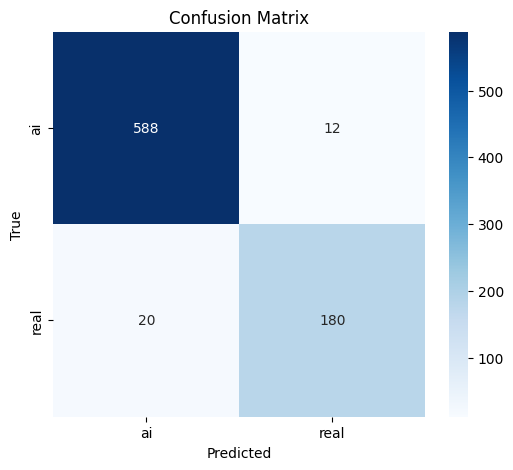

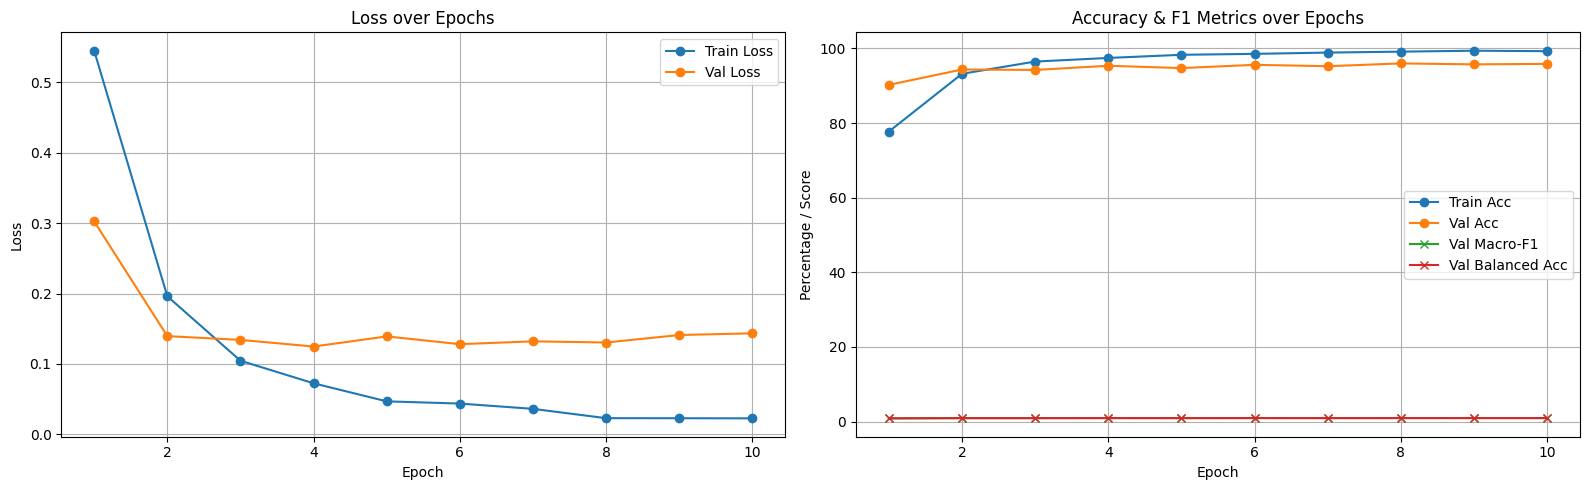

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from collections import Counter
from tqdm import tqdm
from sklearn.metrics import f1_score, balanced_accuracy_score, classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import copy
import pickle

# -------------------------------
# Paths
save_dir = "/content/drive/MyDrive/Dataset"
best_model_path = os.path.join(save_dir, "mobilevitv2_best.pth")
last_checkpoint_path = os.path.join(save_dir, "mobilevitv2_last.pth")
history_path = os.path.join(save_dir, "history.pth")
csv_log_path = os.path.join(save_dir, "training_log.csv")

# -------------------------------
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# -------------------------------
# DataLoader setup (assuming train_dataset and test_dataset are ready)
# WeightedRandomSampler for class imbalance
targets = [s[1] for s in train_dataset.samples]
counts = Counter(targets)
class_weights = {cls: 1.0 / count for cls, count in counts.items()}
sample_weights = [class_weights[t] for t in targets]

sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=2, pin_memory=True)
val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# -------------------------------
# Loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# Mixed precision if CUDA available
scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None

# -------------------------------
# Resume training if checkpoint exists
start_epoch = 0
num_epochs = 10
best_val_acc = 0.0
history = {
    "epoch": [], "train_loss": [], "train_acc": [],
    "val_loss": [], "val_acc": [],
    "val_macro_f1": [], "val_bal_acc": []
}
best_model_wts = copy.deepcopy(model.state_dict())

if os.path.exists(last_checkpoint_path):
    print(f"🔄 Resuming from last checkpoint: {last_checkpoint_path}")
    checkpoint = torch.load(last_checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state'])
    optimizer.load_state_dict(checkpoint['optimizer_state'])
    if 'history' in checkpoint:
        history = checkpoint['history']
    start_epoch = checkpoint['epoch']
    best_val_acc = checkpoint.get('best_val_acc', 0.0)
    print(f"✅ Resumed at epoch {start_epoch}, best_val_acc: {best_val_acc:.4f}")

# -------------------------------
# Training loop
for epoch in range(start_epoch, num_epochs):
    # ---- Train ----
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        if scaler is not None:
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += images.size(0)
        loop.set_postfix(loss=running_loss/total, acc=100*correct/total)

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = 100. * correct / total

    # ---- Validation ----
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += images.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader.dataset)
    val_acc = 100. * val_correct / val_total
    val_macro_f1 = f1_score(all_labels, all_preds, average="macro")
    val_bal_acc = balanced_accuracy_score(all_labels, all_preds)

    # ---- Save metrics ----
    history["epoch"].append(epoch+1)
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    history["val_macro_f1"].append(val_macro_f1)
    history["val_bal_acc"].append(val_bal_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}% | "
          f"Macro-F1: {val_macro_f1:.4f}, Bal Acc: {val_bal_acc:.4f}")

    # ---- Save best model ----
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), best_model_path)
        print(f"💾 Best model saved: {best_model_path}")

    # ---- Save last checkpoint ----
    torch.save({
        "epoch": epoch+1,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "history": history,
        "best_val_acc": best_val_acc
    }, last_checkpoint_path)

    # ---- Save history ----
    torch.save(history, history_path)

    # ---- Save CSV log ----
    pd.DataFrame(history).to_csv(csv_log_path, index=False)

# -------------------------------
# Load best model weights
model.load_state_dict(best_model_wts)
print("✅ Training complete, best model loaded.")

# -------------------------------
# Final evaluation: per-class metrics & confusion matrix
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Replace 'classes' with your dataset classes list: ['real', 'ai']
classes = train_dataset.classes
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=classes))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()



# -------------------------------
# Plot training history
import matplotlib.pyplot as plt

epochs = history["epoch"]

plt.figure(figsize=(16,5))

# ---- Loss ----
plt.subplot(1,2,1)
plt.plot(epochs, history["train_loss"], label="Train Loss", marker='o')
plt.plot(epochs, history["val_loss"], label="Val Loss", marker='o')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# ---- Accuracy & F1 ----
plt.subplot(1,2,2)
plt.plot(epochs, history["train_acc"], label="Train Acc", marker='o')
plt.plot(epochs, history["val_acc"], label="Val Acc", marker='o')
plt.plot(epochs, history["val_macro_f1"], label="Val Macro-F1", marker='x')
plt.plot(epochs, history["val_bal_acc"], label="Val Balanced Acc", marker='x')
plt.title("Accuracy & F1 Metrics over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Percentage / Score")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
